In [1]:
push!(empty!(LOAD_PATH), "@")
using Pkg; Pkg.activate("../DistributedOptimization")

  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`


In [2]:
using Distributed
n_workers = 10
nprocs()==1 || rmprocs(workers()); addprocs(n_workers);

In [3]:
include("./src/DistributedOptimization.jl")

optimize (generic function with 2 methods)

In [4]:
using Distributed
using DistributedArrays

n,m = 50, 20
A = [@spawnat worker rand(n÷nworkers(),m) for worker in workers()]
A = reshape(A, :, 1)
A = DArray(A); # +

x_opt = rand(m,1)

b = [@spawnat worker A.localpart*x_opt + 0.01*rand(Poisson(1),(n÷nworkers(),1)) for worker in workers()]
b = reshape(b, :, 1)
b = DArray(b); # ++

λ = 0.001

x = rand(m,1); epochs = 1000; verbose = epochs÷10;

In [5]:
paper_objective     = PaperObjective(A,b,λ); # initializes worker_objective
paper_solver        = PaperSolver(paper_objective); # initializes worker_solver

history_async_paper = optimize(x, epochs, paper_solver, verbose);

iterations = history_async_paper.iteration; verbose = iterations÷10;
history_sync_paper  = sync_optimize(x, iterations, paper_solver, verbose);

x_star_paper = history_sync_paper.logs["x"][end];

epoch=1, elapsed=0.0
epoch=100, elapsed=16.591025291
epoch=200, elapsed=17.352838916
epoch=300, elapsed=18.122907833
epoch=400, elapsed=18.882562416
epoch=500, elapsed=19.660315583
epoch=600, elapsed=20.440755625
epoch=700, elapsed=21.279581375
epoch=800, elapsed=22.067326083
epoch=900, elapsed=22.864367958
epoch=1000, elapsed=23.639960958
epoch=1, elapsed=0.0
epoch=11209, elapsed=18.614545791
epoch=22418, elapsed=36.399926791
epoch=33627, elapsed=55.379887458
epoch=44836, elapsed=74.483960083
epoch=56045, elapsed=93.629489333


In [6]:
piag_objective     = PiagObjective(A,b,λ); # initializes worker_objective
piag_solver        = PiagSolver(piag_objective); # initializes worker_solver

history_async_piag = optimize(x, epochs, paper_solver, verbose);

iterations=history_async_piag.iteration; verbose = iterations÷10;
history_sync_piag  = sync_optimize(x, iterations, paper_solver, verbose);

x_star_piag = history_sync_piag.logs["x"][end];

epoch=1, elapsed=0.0
epoch=100, elapsed=3.575146333
epoch=200, elapsed=4.349152458
epoch=300, elapsed=5.150331167
epoch=400, elapsed=5.997310875
epoch=500, elapsed=6.823075708
epoch=600, elapsed=7.72672125
epoch=700, elapsed=8.633248042
epoch=800, elapsed=9.540859417
epoch=900, elapsed=10.404347667
epoch=1000, elapsed=11.262901542
epoch=1, elapsed=0.0
epoch=4902, elapsed=8.374992541
epoch=9804, elapsed=16.513866958
epoch=14706, elapsed=24.855939375
epoch=19608, elapsed=33.315148416
epoch=24510, elapsed=41.505382041


In [7]:
# log!(history_async_paper, paper_objective.∇f)
# log!(history_sync_paper,  paper_objective.∇f)
# log!(history_async_piag, piag_objective.∇f)
# log!(history_sync_piag,  piag_objective.∇f)

## Plots

In [8]:
using LinearAlgebra

h(x) = sum(x.*log.(x))
∇h(x) = log.(x)
D(h,∇h,x,y) = h(x) - h(y) - ∇h(y)⋅(x-y)

D (generic function with 1 method)

### Plot algo synchrone

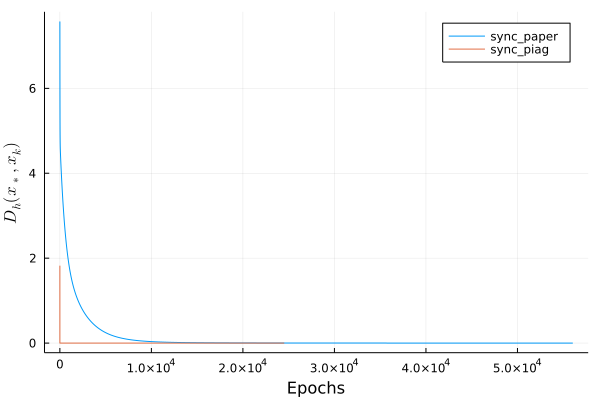

In [17]:
using Plots 
using LaTeXStrings
gr()

# p = "Time"
p = "Epochs" 
# p = "Iterations"

plot()
for (x_star, history, name) in zip([x_star_paper, x_star_piag],[history_sync_paper, history_sync_piag], ["sync_paper", "sync_piag"])
    if p=="Time"
        X = history.logs["elapsed"]
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(X,Y,label=name)
    elseif p=="Epochs"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]][history.logs["epochs"]]
        plot!(Y,label=name) 
    elseif p=="Iterations"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(Y,label=name) 
    end
end
    
xlabel!(p)
ylabel!(L"D_h(x_*,x_k)")

### Plots algo asynchrone

In [22]:
using Plots 
using LaTeXStrings
gr()

# p = "Time"
# p = "Epochs" 
p = "Iterations"

plot()
for (x_star, history, name) in zip([x_star_paper, x_star_piag],[history_async_paper, history_async_piag], ["async_paper", "async_piag"])
    if p=="Time"
        X = history.logs["elapsed"]
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(X,Y,label=name)
    elseif p=="Epochs"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]][history.logs["epochs"]]
        plot!(Y,label=name) 
    elseif p=="Iterations"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(Y,label=name) 
    end
end
    
xlabel!(p)
ylabel!(L"D_h(x_*,x_k)")

# display(plt)

- D_h(x*, xk) (10 000 epochs et ses iterations) n=10 `OK`
- Un prends 10x + de temps que les autres `OK`
- x* calculer avec 1 worker `OK`
- ajouter norm 1 `OK`
- ajouter piag
- compater sync async et piag
- mesure des iterations en temps cpu `OK`
- mesurer delay maximum


- Machine aléatoirement retardé ?

- Factoriser creation du problem `OK`

- tester map reduce travailleur `~OK`

Papier 


Illustration theoreme / D Bregman

vs

Comparaison piag / ||x-x*||